![Lapage](Lapage_logo.png)
# Contexte
Lapage était originellement une librairie physique avec plusieurs points de vente. 
Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. 
Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

# Missions
- Réaliser une analyse des différents indicateurs de vente :
    - Le CA (indicateurs et graphiques) et son évolution dans le temps via la mise en place d'une décomposition en moyenne mobile pour évaluer la tendance globale;
    - Zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.;
    - Focus sur les profils des clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
- Fournir une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques. 
    - Etablir le lien entre le genre d’un client et les catégories des livres achetés.
    - Faire divers corrélations entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés.



# Préparation des données 

## Initialisation du projet

### Import des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # pour gérer l'affichage date dans les axes graphiques
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta, datetime
import six # for sexy dataframe
import matplotlib.ticker as ticker # pour gérer les axes des graphiques

#Pour les analyses bivariées 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from math import *

### Paramètres

In [2]:
%matplotlib inline 
# On indique que l'on veut voir apparaître les graphiques dans le notebook, sinon on ne verrait rien

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 20)

### Import des fichiers

In [3]:
path='./Fichiers csv/'
customers_df = pd.read_csv(path+"customers.csv")
products_df=pd.read_csv(path+"products.csv")
transactions_df=pd.read_csv(path+"transactions.csv")

### Variables ou classes

Avant de commencer, je stocke le nombre de lignes et de colonnes de chacun des fichiers

In [4]:
customers_initial_size=customers_df.shape
products_intial_size=products_df.shape
transactions_intial_size=transactions_df.shape

Style des graphiques Seaborn

In [5]:
sns.set(style="whitegrid")

#### Classes

In [6]:
def calculate_age_range(age):
    """
    This function creates an age range based on age.
    Parameters are :
    - age
    It returns
    - an age range
    
    The data range is 75 years (from 19 to 94 years old).
    In order to compare the number of clients per range range, it is necessary to ensure that the size of these ranges is (more or less) identical!
    """

    if age < 35:
        return "18-35"
    elif 35 <= age < 50 :
        return "35-50"
    elif 50 <= age <= 65:
        return "50-65"
    elif 65 <= age < 80:
        return "65-80"
    elif age >= 80:
        return "80 et +"


In [7]:

def render_mpl_table(data, title,colLabels, col_width=3.0, row_height=0.625, font_size=14,
header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',bbox=[0, 0, 1, 1], header_columns=0):

    """
    Dataframe configuration function for export -> retrieved from internet
    Params = dataframe, title, name of columns and setting up.
    """
    size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
    fig, ax = plt.subplots(figsize=size)
    ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=colLabels)
    #mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    plt.ioff()
    plt.savefig('img/'+title+".png", dpi=200)

## Analyse de la qualité des données

In [8]:
customers_df.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [9]:
products_df.tail()

,id_prod,price,categ
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0


In [10]:
transactions_df.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


### Erreurs de type

In [11]:
customers_df.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [12]:
products_df.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [13]:
transactions_df.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

**<u>Observation</u><br>**
La seule chose qui semble être problématique est la variable date qui n'est pas considérée comme une date. <br>
On peut corriger cela via la fonction to_datetime de pandas. <br>

**<u>Méthode</u><br>**
En lançant la commande de transformation du type object en date, on s'aperçoit que la conversion est bloquée par une erreur : "Unknown string format: test_2021-03-01 02:30:02.237419"<br>
Avant de relancer la conversion, j'identifie toutes les dates ayant le mot "test" et je les stocke dans un nouveau dataframe avant de les supprimer de mon fichier.
Je lance ensuite ma conversion au format date.

In [14]:
mask = np.column_stack([transactions_df["date"].str.contains("test", na=False) for col in transactions_df])
test_dates_transactions_df=transactions_df.loc[mask.any(axis=1)]
test_dates_transactions_df.head()

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0


In [15]:
transactions_df.drop(test_dates_transactions_df.index, inplace=True)

In [16]:
transactions_df.shape

(679332, 4)

In [17]:
transactions_df.date=pd.to_datetime(transactions_df.date)
transactions_df.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

### Valeurs manquantes

Je vérifier si mon jeu de données contient des valeurs manquantes (Null ou NaN)

In [18]:
customers_df.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [19]:
products_df.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [20]:
transactions_df.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

**<u>Observation</u><br>**
Il n'y a pas de valeurs NaN ou None

### Doublons

Pour identifier les doublons, je me base sur des clés qui ne devraient pas contenir d'informations en double<br>
- customer : le client_id doit être unique puisqu'il constitue la clé primaire;<br>
- products : le id_prod doit être unique puisqu'il constitue la clé primaire;<br>
- transactions : ce qui constituerait une transaction unique est l'ensemble id_prod + client_id + date.

In [21]:
customers_df.loc[customers_df["client_id"].duplicated(keep=False),:]

,client_id,sex,birth


In [22]:
transactions_df.loc[transactions_df[["id_prod","date","client_id"]].duplicated(keep=False)]

,id_prod,date,session_id,client_id


**<u>Observation</u><br>**
Il n'y a pas de doublon dans les données

### Détection d'anomalies

Un describe peut potentiellement nous aider dans un premier temps.<br>

In [23]:
customers_df.describe(include="all")

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


<u>**Observation**</u><br>
Pour la table customer, rien ne semble anormal : les années de naissances vont de 1929 à 2004, et il n'y a que 2 valeurs pour le sexe.<br>

In [24]:
products_df.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


**<u>Observation</u><br>**
La plus faible valeur est négative. Sans présumer de la valeur des livres, un prix négatif est forcément une erreur.

Recherche de prix négatifs ou valant 0

In [25]:
products_df[products_df.price<=0]

,id_prod,price,categ
731,T_0,-1.0,0


Le prix négatif a un id différent des autres car incluant une lettre. On pourrait assumer qu'il s'agit d'une erreur et supprimer cette ligne.
Je vérifie avant si je retrouve ce produit dans la table transaction qui est liée à la table products.

In [26]:
transactions_df[transactions_df.id_prod=="T_0"]

,id_prod,date,session_id,client_id


Je vérifie en passant si ce produit se trouve dans la table de test.

In [27]:
test_dates_transactions_df[test_dates_transactions_df=="T_0"].count()

id_prod       200
date            0
session_id      0
client_id       0
dtype: int64

Le produit est un produit test, il n'est pas présent dans la table transactions nettoyée. Je supprime la ligne.

In [28]:
products_df.drop(products_df[products_df.price<=0].index, inplace=True)

### Conclusion

Un type de données a été modifié.<br>
Aucune valeur manquante n'a été identifiée.<br>
Aucun doublon n'a été détecté.<br>
Des lignes ont été supprimées :
 - Les lignes de tests
 - Les lignes contenant des prix négatifs


In [29]:
customers_final_size=customers_df.shape
products_final_size=products_df.shape
transactions_final_size=transactions_df.shape

print (f"""
Le fichier 'customers.csv' contenait initialiement {customers_initial_size[0]} lignes et {customers_initial_size[1]} colonnes. 
Il contient maintenant {customers_final_size[0]} lignes et {customers_final_size[1]} colonnes. 

Le fichier 'products.csv' contenait initialiement {products_intial_size[0]} lignes et {products_intial_size[1]} colonnes. 
Il contient maintenant {products_final_size[0]} lignes et {products_final_size[1]} colonnes. 

Le fichier 'transactions.csv' contenait initialiement {transactions_intial_size[0]} lignes et {transactions_intial_size[1]} colonnes. 
Il contient maintenant {transactions_final_size[0]} lignes et {transactions_final_size[1]} colonnes. 
""")


Le fichier 'customers.csv' contenait initialiement 8623 lignes et 3 colonnes. 
Il contient maintenant 8623 lignes et 3 colonnes. 

Le fichier 'products.csv' contenait initialiement 3287 lignes et 3 colonnes. 
Il contient maintenant 3286 lignes et 3 colonnes. 

Le fichier 'transactions.csv' contenait initialiement 679532 lignes et 4 colonnes. 
Il contient maintenant 679332 lignes et 4 colonnes. 



## Fusion des différents jeux de données

Pour faciliter la manipulation et la lecture des données, je merge les 3 fichiers dans un seul tableau.<br>
Le tableau "principal" est transactions car il a les 2 clés étrangères des 2 autres tables.

In [30]:
main_df=(
    transactions_df
        .merge(customers_df, how="left")
        .merge(products_df, how="left")
)
main_df

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0.0
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,15.99,1.0
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,7.99,0.0
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,69.99,2.0
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,4.99,0.0
...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,f,1951,12.99,0.0
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,f,1977,10.99,1.0
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,f,1988,12.99,0.0
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,m,1986,4.98,0.0


Ayant réalisé une jointure gauche, je vérifie s'il y a des lignes nulles.

In [31]:
null_rows=main_df[main_df.isnull().any(axis=1)]                          
print(f"Il y a {len(null_rows)} transactions dont au moins une valeur est nulle.")
if (len(null_rows) > 0):
    if int(len(null_rows.id_prod.unique())>1):
        print(f"{len(null_rows.id_prod.unique())} produits sont concernés : {','.join(str(i) for i in null_rows.id_prod.unique())}")
    else:
        print(f"Le produit concerné par ses transactions est le {''.join(null_rows.id_prod.unique())}") 

Il y a 221 transactions dont au moins une valeur est nulle.
Le produit concerné par ses transactions est le 0_2245


In [32]:
null_rows.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,m,1940,NaN,NaN
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,f,1963,NaN,NaN
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,m,1978,NaN,NaN
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,m,1991,NaN,NaN
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,m,1973,NaN,NaN


Je regarde dans quelles colonnes nous avons des valeurs de type NaN.

In [33]:
main_df.isnull().any(axis=0)

id_prod       False
date          False
session_id    False
client_id     False
sex           False
birth         False
price          True
categ          True
dtype: bool

Le produit a été vendu 221 fois, le supprimer nous ferait perdre des informations de CA pour notre analyse, même si le volume est assez faible.<br>
Je vais appliquer le prix moyen au produit manquant, et la catégorie ayant le plus grand nombre de ventes.

In [34]:
mean_price=round(np.mean(main_df.price),2)
most_numerous_categ = main_df.groupby("categ", as_index=False).agg({"categ":'count'}).reset_index().sort_values(by="categ",ascending=False)

print(f"""Le prix moyen d'un livre est de {mean_price}€.
La catégorie la plus vendue est la {most_numerous_categ.index[0]} avec {most_numerous_categ.categ[0]} occurences.""")

Le prix moyen d'un livre est de 17.45€.
La catégorie la plus vendue est la 0 avec 415459 occurences.


In [35]:
main_df.price.fillna(value=mean_price,inplace=True)
main_df.categ.fillna(value=most_numerous_categ.index[0], inplace=True)

Vérification de la modification

In [36]:
# I check my modification by searching the index of the 1st row of the array null_rows (index=2633).
main_df.iloc[2633]

id_prod                           0_2245
date          2022-09-23 07:22:38.636773
session_id                      s_272266
client_id                         c_4746
sex                                    m
birth                               1940
price                              17.45
categ                                0.0
Name: 2633, dtype: object

In [37]:
main_df.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
sex                   object
birth                  int64
price                float64
categ                float64
dtype: object

Le champ categ est devenu float au lieu d'un entier.<br>
Je modifie en int.

In [38]:
main_df.categ=main_df.categ.astype('int')
main_df.categ.dtypes

dtype('int64')

## Ajout de données

Pour les analyses demandées, je vais avoir besoin de décomposer la date d'achat, de connaître l'âge des clients et leur tranche d'âge.

Ajout de données issues de la colonne *date* : 
- année
- année-mois

In [39]:
main_df['purchase_year'] = main_df['date'].dt.year
main_df['purchase_year_month'] = main_df['purchase_year'].astype(str) + '-' + main_df['date'].dt.strftime('%m').astype(str)

Ajout d'une colonne *age* du client en fonction de l'année courante du jeu de données.

In [40]:
#Dataset has data in the future (2023 as we are in 2022).
#I can't retrieve the current year to compute age. I fetch the max year from dataset.

currentYear=max(main_df["date"].dt.year)
currentYear
main_df["age"]=currentYear-main_df.birth

Ajout de la tranche d'âge

In [41]:
main_df["age_range"]=main_df.age.apply(calculate_age_range)
main_df

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_year_month,age,age_range
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,2022-05,37,35-50
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,15.99,1,2022,2022-02,35,35-50
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,7.99,0,2022,2022-06,55,50-65
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,69.99,2,2021,2021-06,23,18-35
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,4.99,0,2023,2023-01,43,35-50
...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,f,1951,12.99,0,2022,2022-01,72,65-80
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,f,1977,10.99,1,2022,2022-03,46,35-50
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,f,1988,12.99,0,2022,2022-12,35,35-50
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,m,1986,4.98,0,2021,2021-07,37,35-50


# Analyse univariée des différentes variables

- Produit (prix, top ventes, volumes de ventes par catégorie)
- CA
- Client (âge, genre, habitudes de consommation)

## Produit

In [42]:
number_of_products = main_df.id_prod.nunique()
print (f"Lapage propose {number_of_products} références.")

Lapage propose 3266 références.


### Calcul du prix moyen par catégorie

In [43]:
# I create an empty dictionnary 
price_per_categ = {}

# I iterate over each category and store the average price for each one, with key = category and value = average.
for i in range (len(main_df.categ.unique())): 
    price_per_categ[i] = round(np.mean(main_df[main_df["categ"]==i]["price"]),2)

# Display of stored information 
for categ, price in price_per_categ.items():
    print("Le prix moyen d'un livre de la catégorie", categ, "vaut", price,"€")


Le prix moyen d'un livre de la catégorie 0 vaut 10.64 €
Le prix moyen d'un livre de la catégorie 1 vaut 20.49 €
Le prix moyen d'un livre de la catégorie 2 vaut 76.21 €


### Nombre de références par catégorie

In [44]:
# I create an empty dictionnary 
total_per_categ = {}

# I iterate over each category and store the average price for each one, with key = category and value = average.
for i in range (len(main_df.categ.unique())): 
    total_per_categ[i] = main_df[main_df["categ"]==i].count()["id_prod"]

# Display of stored information 
for categ, total in total_per_categ.items():
    print(f"Il y a {total} livres dans la catégorie {categ}.")


Il y a 415680 livres dans la catégorie 0.
Il y a 227169 livres dans la catégorie 1.
Il y a 36483 livres dans la catégorie 2.


### Volume de ventes par catégorie

In [45]:
categ_data=main_df.groupby(["categ"])
categ_data=categ_data.size().reset_index(name='total')
categ_data

,categ,total
0,0,415680
1,1,227169
2,2,36483


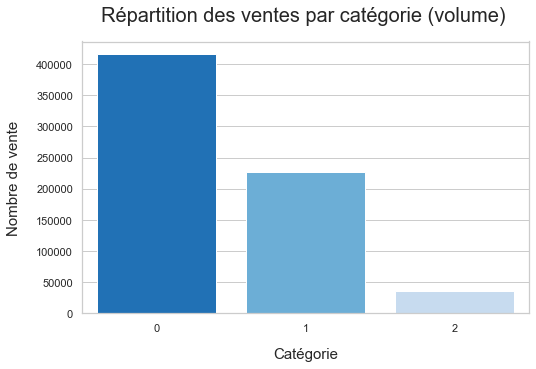

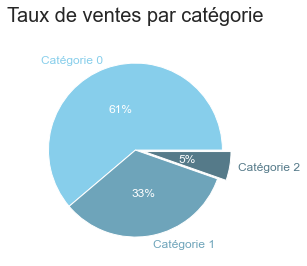

In [46]:
# Sales volume representation

# Create graphic
plt.figure(figsize=(8,5))

sns.barplot(x="categ" , y="total",data=categ_data, palette = "Blues_r", saturation=1)
sns.set_theme(style="whitegrid")

plt.xlabel("Catégorie", fontsize = 15, labelpad=15)
plt.ylabel("Nombre de vente", fontsize = 15, labelpad=15)
plt.title("Répartition des ventes par catégorie (volume) ", fontsize = 20,loc='center', pad=20)
#colors = sns.color_palette('colorblind')

# Save the graphic
plt.savefig('img/numOfSalesByCateg.png', dpi=200, bbox_inches="tight")

# Show graphic
plt.show()

#=============================================================================
# Sales volume representation by percentage

#Define Seaborn color palette to use
#colors = sns.color_palette(palette='pastel')[6:]
colors = sns.dark_palette("skyblue", 5, reverse=True)
explode = [0, 0, 0.1]

labels=categ_data.categ.apply(lambda x : "Catégorie " + str(x))

plt.tight_layout()

# Retrieving data
data = categ_data.total

# Create and show pie chart
patches,texts,pcts = plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%',pctdistance=0.5, explode=explode,textprops={'color':"w","fontsize":12})

# For each wedge, set the corresponding text label color to the wedge's face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    
# Style just the percent values.
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=60)

plt.title('Taux de ventes par catégorie', size=20, pad=20, loc="center")

# Save the graphic
plt.savefig(fname='img/propSalesByCateg.png', dpi=200, bbox_inches="tight") 

plt.show()

### Total des ventes par catégorie

In [47]:
categ_price_data = main_df[["price","categ"]].groupby('categ').agg({"price":"sum"}).reset_index()
categ_price_data

,categ,price
0,0,4423587.42
1,1,4653722.69
2,2,2780275.02


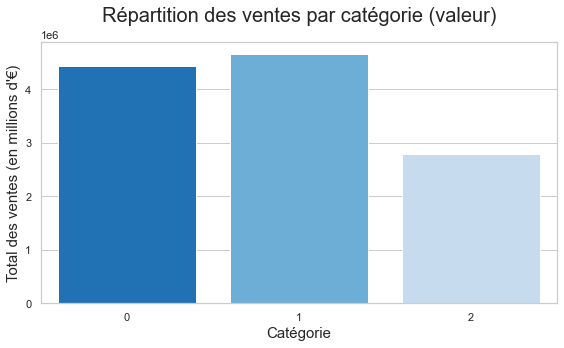

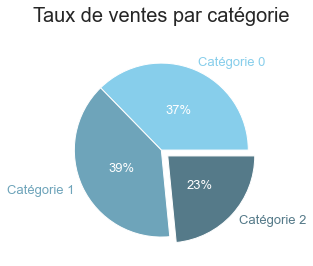

In [48]:
# Turnover representation
# Prepare graphic
plt.figure(figsize=(8,5))

sns.barplot(x="categ" , y="price",data=categ_price_data, palette = "Blues_r", saturation=1)

plt.xlabel("Catégorie", fontsize = 15)
plt.ylabel("Total des ventes (en millions d'€)", fontsize = 15)
plt.title("Répartition des ventes par catégorie (valeur)", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

# Save the graphic
plt.savefig(fname='img/totalSalesByCateg.png', dpi=200, bbox_inches="tight")  

# Show graphic
plt.show()

#=============================================================================

# Turnover representation by  percentage

#Define Seaborn color palette to use
colors = sns.dark_palette("skyblue", 5, reverse=True)
explode = [0, 0, 0.1]

labels=categ_price_data.categ.apply(lambda x : "Catégorie " + str(x))

plt.tight_layout()

# Rietrieving data
data = categ_price_data.price

# Create and show pie chart
patches,texts,pcts = plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%',pctdistance=0.5, explode=explode,textprops={"fontsize":13})

# For each wedge, set the corresponding text label color to the wedge's face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    
# Style just the percent values.
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=60)

# General layouts
plt.title('Taux de ventes par catégorie', loc="center", fontsize = 20, pad=20)

# Save  graphic
plt.savefig(fname='img/propTotalSalesByCateg.png', dpi=200, bbox_inches="tight") 

# Show graphic
plt.show()

**<u>Observation</u>**<br>
La catégorie 0 se vend le mieux, mais le prix moyen étant bas, ça ne représente pas la plus grosse part du CA.<br>
La catégorie 2 se vend peu mais son prix moyen élevé permet la réalisation d'un bon CA.

### Produits les plus et moins vendus

In [49]:
top_flop=main_df[["id_prod", "price", "categ"]].groupby(['id_prod','categ',"price"], as_index=False).agg(sales=("price","count"),total_sales=("price",'sum')).round(2).sort_values(["sales","total_sales"], ascending=False)

In [50]:
#Top 10
top=top_flop.head(10)

# Moins de 1 vente pour un total de moins de 3€
flop=top_flop[(top_flop["total_sales"]<=3) & (top_flop["sales"]<=1)]

print (f"""Le top {len(top)} meilleures références est le suivant :
{(top)}
-----------------------------------------------
Les {len(flop)} moins bonnes ventes sont :
{(flop)}
""")


Le top 10 meilleures références est le suivant :
     id_prod  categ  price  sales  total_sales
2592   1_369      1  23.99   2252     54025.48
2645   1_417      1  20.99   2189     45947.11
2642   1_414      1  23.83   2180     51949.40
2734   1_498      1  23.37   2128     49731.36
2654   1_425      1  16.99   2096     35611.04
2630   1_403      1  17.99   1960     35260.40
2640   1_412      1  16.65   1951     32484.15
2641   1_413      1  17.99   1945     34990.55
2633   1_406      1  24.81   1939     48106.59
2634   1_407      1  15.99   1935     30940.65
-----------------------------------------------
Les 12 moins bonnes ventes sont :
     id_prod  categ  price  sales  total_sales
166   0_1151      0   2.99      1         2.99
417   0_1379      0   2.99      1         2.99
752   0_1683      0   2.99      1         2.99
1793   0_549      0   2.99      1         2.99
2109   0_833      0   2.99      1         2.99
549   0_1498      0   2.48      1         2.48
802   0_1728      0   2

Sauvegarde des tableaux

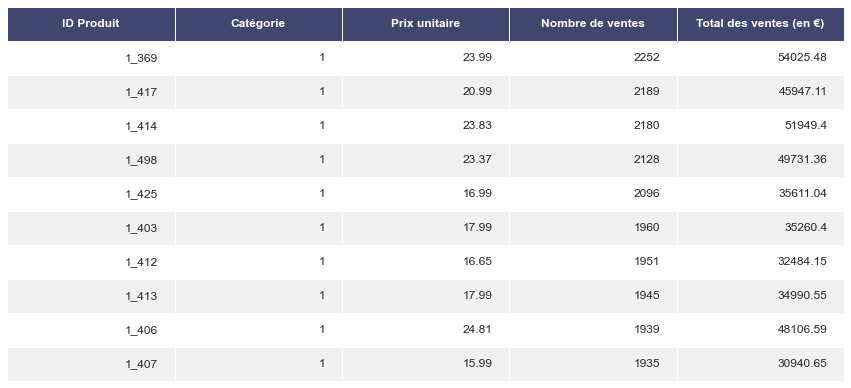

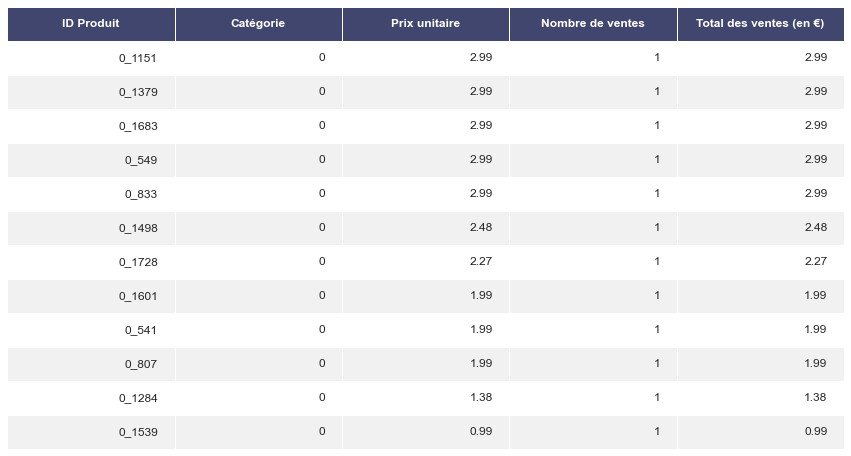

In [51]:
colLabels=["ID Produit","Catégorie","Prix unitaire","Nombre de ventes","Total des ventes (en €)"]
render_mpl_table(top,title="top",colLabels=colLabels)
render_mpl_table(flop,title="flop",colLabels=colLabels)

Calcul du CA global

In [52]:
total_turnover=main_df.groupby('client_id', as_index=False).agg(total_achat=('price','sum')).sort_values("total_achat")
total_turnover=ceil(total_turnover.total_achat.sum())
percentage_top=top.total_sales.sum()/total_turnover

print (f"""Le CA de Lapage s'élève à {total_turnover}€.
Le top 10 représente {percentage_top:.2%} du CA, soit {total_turnover*percentage_top}€.""")

Le CA de Lapage s'élève à 11857586€.
Le top 10 représente 3.53% du CA, soit 419046.73€.


## Chiffre d'affaires

### CA annuel

Comme on ne sait pas si les années "extrêmes" sont complètes, on va calculer le CA glissant par tranche de 12 mois.

In [53]:
price_data = main_df[["price", "purchase_year", "purchase_year_month"]]

Calcul CA par mois

In [54]:
turnover_per_yearmonth=price_data.groupby("purchase_year_month").agg(turnover_per_yearmonth=("price","sum")).reset_index()
turnover_per_yearmonth

,purchase_year_month,turnover_per_yearmonth
0,2021-03,482597.66
1,2021-04,476353.60
2,2021-05,493083.07
3,2021-06,484210.71
4,2021-07,482905.20
5,2021-08,482441.84
6,2021-09,507450.08
7,2021-10,320920.89
8,2021-11,516342.23
9,2021-12,526039.43


In [55]:
'''
Rolling year calculation
Iterate over each row of the turnover_per_yearmonth dataframe.
If the modulo of the index of  "current line /12" equals 0, then we have reached 12 months, so we change the rolling year to the next one.
'''

j=min(main_df.purchase_year)
turnover_per_yearmonth["year"]=""
for i in range (0,len(turnover_per_yearmonth)):
    turnover_per_yearmonth.loc[turnover_per_yearmonth.index==i, "year"] = str(j)+"-"+str(j+1)
    if (i+1)%12==0: 
        j+=1

In [56]:
check_nb_months=turnover_per_yearmonth.groupby("year").agg(number_of_months=("year",'count')).reset_index()
turnover_per_yearmonth=turnover_per_yearmonth.merge(check_nb_months, how="inner")
turnover_per_yearmonth

,purchase_year_month,turnover_per_yearmonth,year,number_of_months
0,2021-03,482597.66,2021-2022,12
1,2021-04,476353.60,2021-2022,12
2,2021-05,493083.07,2021-2022,12
3,2021-06,484210.71,2021-2022,12
4,2021-07,482905.20,2021-2022,12
5,2021-08,482441.84,2021-2022,12
6,2021-09,507450.08,2021-2022,12
7,2021-10,320920.89,2021-2022,12
8,2021-11,516342.23,2021-2022,12
9,2021-12,526039.43,2021-2022,12


Je vérifie qu'il y a bien 12 mois par période, sinon je supprime les lignes pour ne pas les prendre en compte dans les graphes puisqu'on veut un CA annuel.

In [57]:
turnover_12_months=turnover_per_yearmonth.groupby(["year","number_of_months"]).agg(turnover_12_months=("turnover_per_yearmonth","sum")).reset_index()#retirer après df [["year","number_of_months","turnover_per_yearmonth"]]
turnover_12_months.drop(turnover_12_months.loc[turnover_12_months["number_of_months"]!=12].index,inplace=True)
turnover_12_months

,year,number_of_months,turnover_12_months
0,2021-2022,12,5833534.40
1,2022-2023,12,6024050.73


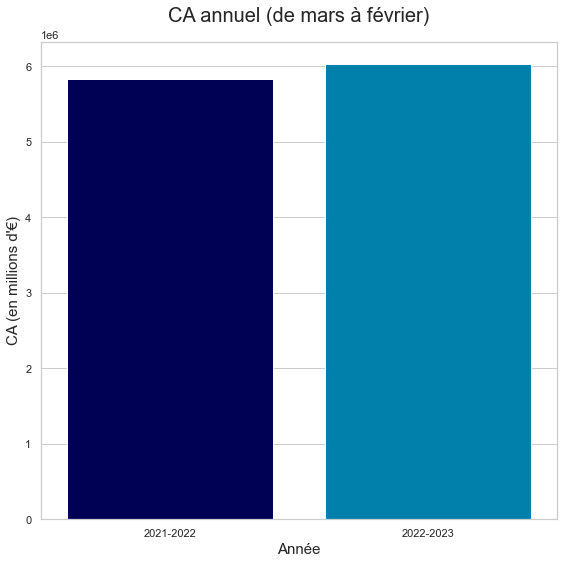

In [58]:
# Prepare graphic
plt.figure(figsize=(8,8))
color=["#cb453e","#9d262a"]
sns.barplot(x="year" , y="turnover_12_months",data=turnover_12_months, palette="ocean", saturation=1)

plt.xlabel("Année", fontsize = 15)
plt.ylabel("CA (en millions d'€)", fontsize = 15)
plt.title("CA annuel (de mars à février)", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

plt.savefig("img/rollingTurnover.png", dpi=200, bbox_inches="tight")

plt.show()

**<u>Observation</u><br>**
Le CA a augmenté d'une année sur l'autre.

### Evolution du CA 

Pour suivre l'évolution du chiffre d'affaire, le suivi quotidien et sa représentation en courbe est préférable.

**Ventes par jour**

Après avoir identifié un problème en octobre 2021 (baisse du CA), je lisser les données afin d'avoir une idée de la tendance globale avec le calcul la moyenne mobile sur 30 jours.

In [59]:
turnover_per_day=price_data.groupby(pd.to_datetime(main_df['date']).dt.date).agg(turnover_per_day=("price","sum")).reset_index()
moving_average_day=turnover_per_day["turnover_per_day"].rolling(30, center=True).mean()
turnover_per_day["moving_average"]=moving_average_day

Superposition des courbes de CA normale et lissée

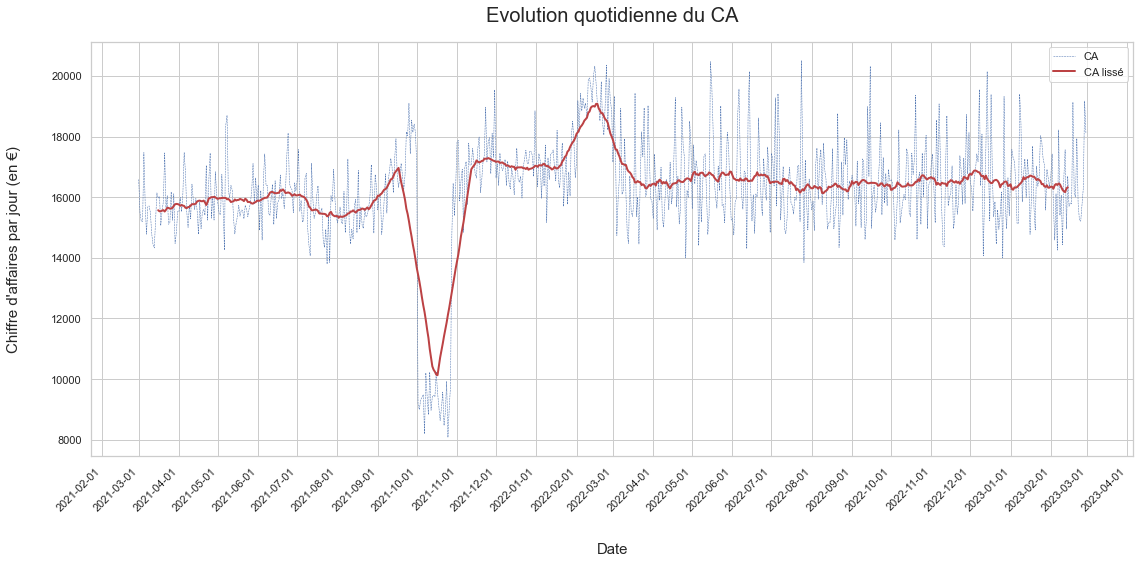

In [60]:
# set figure size and labels orientation
fig, ax = plt.subplots(figsize=(16, 8))
fig.autofmt_xdate(rotation=45)

# Graphics
plt.plot(turnover_per_day.pivot_table(values='turnover_per_day',index='date'), linestyle="dashed", linewidth=0.5,label="CA")
plt.plot(turnover_per_day.pivot_table(values='moving_average',index='date'), color="#bc4244", linewidth=2,label="CA lissé")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))# Format the date on x axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Ensure ticks fall once every month (interval=1) 

# Add titles
plt.title("Evolution quotidienne du CA", loc='center', fontsize=20, pad=20)
plt.xlabel("Date",labelpad=30, fontsize=15)
plt.ylabel("Chiffre d'affaires par jour (en €)",labelpad=30, fontsize=15)

plt.tight_layout()

#ax.set_ylim(bottom=0)#commencer le graphe à 0 sur l'axe y

# Place legend
plt.legend(loc="best", ncol=1)

#Save graphgic
plt.savefig("img/turnoverTrend.png", dpi=200, bbox_inches="tight")

# Show the graph
plt.show()


**<u>Observations</u><br>**
Le 3ème trimestre 2021 est en baisse. Les chiffres reprennent leur croissance dès le dernier trimestre 2021.<br>
Après un pic début 2022, les ventes sont en baisse mais restent supérieures au niveau de 2021.<br>

### CA Octobre 2021

L'évolution du CA met en évidence une baisse des ventes en octobre.<br>
Comme les ventes sont disparates selon les catégories, on va regarder l'évolution par catégorie.

In [61]:
october_sales=main_df.copy()
october_sales=october_sales[october_sales["purchase_year_month"] == "2021-10"].groupby(["categ",pd.to_datetime(main_df['date']).dt.date]).agg(total_sales=("price","sum")).round(2).reset_index()

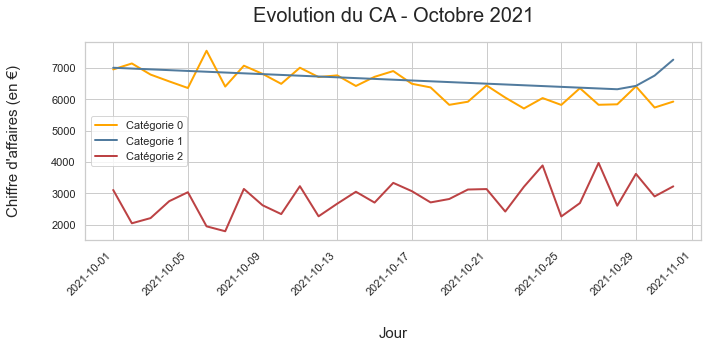

In [62]:
# Make a data frame with all data we're interesting in 
graph=pd.DataFrame({'x': october_sales["date"], 'y1': october_sales["total_sales"][october_sales["categ"]==0],'y2': october_sales["total_sales"][october_sales["categ"]==1],'y3': october_sales["total_sales"][october_sales["categ"]==2]})

# set figure size
fig, ax = plt.subplots(figsize=(10, 5))
fig.autofmt_xdate(rotation=45)

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m-%d'))
#ax.xaxis.set_major_locator(mdates.DayLocator(1))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5)) # Ensure ticks fall once every month (interval=1) 

# Graphics
plt.plot(graph['x'], graph['y1'], marker='', color="orange", linewidth=2,  label="Catégorie 0")

plt.plot(graph['x'], graph['y2'], marker='', color="#517b9e", linewidth=2, label="Categorie 1")

plt.plot(graph['x'], graph['y3'], marker='', color="#bc4244", linewidth=2, label="Catégorie 2")

# Place legend
plt.legend(loc='best', ncol=1)

# Add titles
plt.title("Evolution du CA - Octobre 2021", loc='center', fontsize=20, fontweight=0, pad=20)
plt.xlabel("Jour",labelpad=30, fontsize=15)
plt.ylabel("Chiffre d'affaires (en €)",labelpad=30, fontsize=15)
plt.tight_layout()


#Save graphgic
plt.savefig("img/turnoverTrendByCateg.png", dpi=200, bbox_inches="tight")

# Show the graph
plt.show()


**<u>Observation</u>**<br>
On voit un potentiel problème sur la catégorie 1 dont la courbe est linéaire.

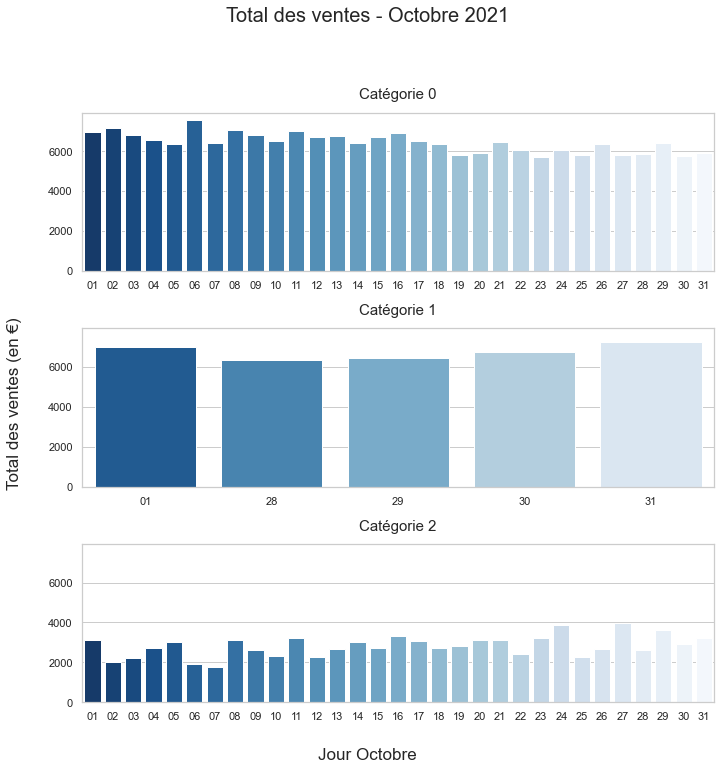

In [63]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=True)
fig.suptitle("Total des ventes - Octobre 2021", fontsize=20,y=1.05)

for i in range (len(october_sales.categ.unique())):
    sns.barplot(ax=axes[i], x=october_sales[october_sales["categ"]==i].date.astype('str').str[8:10] , y=october_sales[october_sales["categ"]==i].total_sales, palette="Blues_r")
    axes[i].set_title("Catégorie "+ str(i),fontsize=15,y=1.05)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.supylabel("Total des ventes (en €)",x=0, fontsize=17)
fig.supxlabel("Jour Octobre",y=0, fontsize=17)
plt.tight_layout()

# Save the graphic
plt.savefig(fname='img/octoberSales.png', dpi=200, bbox_inches="tight")

# Show graphic
plt.show()


**Zoom sur la catégorie 1 en octobre 2021**

In [64]:
#Contrôle fonction
#oct_df=pd.DataFrame({"date":["2021-10-01","2021-10-02","2021-10-10","2021-10-11","2021-10-28","2021-10-29","2021-10-30","2021-10-31"]})
#oct_df.date=pd.to_datetime(oct_df.date,format="%Y-%m-%d").dt.date
#oct_df.dtypes

In [65]:
'''
Identifying when starts and ends the issue
Saving
- the last date before the gap
- the first date ending the gap
Converting the date to a french readable format
'''
oct_df=october_sales[october_sales["categ"]==1]['date']
last_transaction_before_issue=""
first_transaction_after_issue=""
                  
i=0
while i<len(oct_df):
    day_after_current_date=oct_df.values[i] + timedelta(days=1) #I add a day to the current date
    if i+1<len(oct_df):
        if oct_df.values[i+1] != day_after_current_date : #if the next row is different from the day after the current date, then we have a gap
            if last_transaction_before_issue=="": # save the first last date before the gap 
                last_transaction_before_issue=oct_df.values[i]
            first_transaction_after_issue=oct_df.values[i+1] # save the first date after issue is over
        i+=1
    else:
        break
last_transaction_before_issue=last_transaction_before_issue.strftime("%d/%m/%Y")
first_transaction_after_issue=first_transaction_after_issue.strftime("%d/%m/%Y")

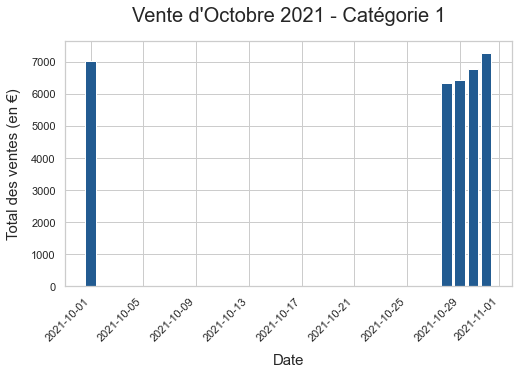

Il y a un problème sur la vente de livres de la catégorie 1 entre le 01/10/2021 et le 28/10/2021.


In [66]:
# Plot category 1 in october
graph = october_sales[october_sales["categ"]==1]
fig, ax = plt.subplots(figsize=(8,5))
fig.autofmt_xdate(rotation=45)

ax.bar(graph['date'], graph['total_sales'],color="#225b91")

# General layouts
plt.title("Vente d'Octobre 2021 - Catégorie 1", loc='center', fontsize=20, fontweight=0, pad=20)
plt.xlabel("Date", fontsize = 15, labelpad=10)
plt.ylabel("Total des ventes (en €)", fontsize = 15, labelpad=10)

plt.savefig(fname='img/octoberSalesIssue.png', dpi=200, bbox_inches="tight") 

plt.show()

print(f"Il y a un problème sur la vente de livres de la catégorie 1 entre le {last_transaction_before_issue } et le {first_transaction_after_issue}.")


**<u>Observation</u>**<br>
Il n'y a pas de ventes entre le 2 et le 27 octobre 2021 sur la catégorie 1.

## Client

Informations :<br>
- Genre : Répartition homme/femme + répartition du CA
- Age : Répartition par tranche d'âge  + répartition du CA
- Habitudes d'achat : Panier moyen, nombre de produits par session, analyse de la concentration des dépenses

Je créé un tableau de clients uniques :<br>
- Passer la colonne sex en minuscule.<br>
- Supprimer tous les doublons pour ne garder que les clients uniques

In [67]:
#Convert data "sex" in lower case
main_df["sex"]=main_df["sex"].str.lower()
clients_df=main_df.drop_duplicates(subset=["client_id","sex","age"]).copy()
clients_df.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_year_month,age,age_range
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,2022-05,37,35-50
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,15.99,1,2022,2022-02,35,35-50
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,7.99,0,2022,2022-06,55,50-65
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,69.99,2,2021,2021-06,23,18-35
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,4.99,0,2023,2023-01,43,35-50


### Age

**Mode opératoire :**
- Vérification de la distribution de l'âge dans notre population
- Utilisation de tranches d'âge pour faciliter la lecture de la distribution

In [68]:
client_by_age=clients_df.groupby("age").agg(occurence=("age","count")).reset_index().sort_values("occurence", ascending=False)
client_by_age.head()

,age,occurence
0,19,437
25,44,215
16,35,207
18,37,203
26,45,199


Calcul de la modalité, de la moyenne et de la médiane de l' âge

In [69]:
mod_age=client_by_age.iloc[client_by_age['occurence'].idxmax(), 0]#Sortie de la 1ère colonne d'index ayant la valeur maximale de count.

median_age=np.median(clients_df.age)

mean_age=np.mean(clients_df.age)

print (f"L'âge le plus représenté est {mod_age} ans, l'âge médian se situe à {median_age:.0f} ans et la moyenne à {mean_age:.0f} ans.")

L'âge le plus représenté est 19 ans, l'âge médian se situe à 44 ans et la moyenne à 45 ans.


In [70]:
clients_df.age.describe()

count    8600.000000
mean       44.739302
std        16.908755
min        19.000000
25%        31.000000
50%        44.000000
75%        57.000000
max        94.000000
Name: age, dtype: float64

**<u>Observation</u><br>**
L'âge le plus représenté est aussi l'âge minimum

Vérification de l'existence d'outlier sur l'âge

In [71]:
q1_age=np.median(clients_df[clients_df.age<=median_age]["age"])
q3_age=np.median(clients_df[clients_df.age>median_age]["age"])
iqr_age=q3_age-q1_age
outlier_q1_age=q1_age-(1.5*iqr_age)
outlier_q3_age=q3_age+(1.5*iqr_age)

print(f"""Les outliers d'âge sont fixés à {outlier_q1_age} et {outlier_q3_age} ans
L'âge minimal de notre jeu de données est {min(clients_df.age)} ans et l'âge maximal {max(clients_df.age)} ans.""")
if outlier_q1_age<min(clients_df.age):
    print (f"Il n'y a pas d'outlier sur l'âge minimum.")
else :
    print (f"On trouve au moins un âge dans ce que l'on considère comme outlier")
if outlier_q3_age>max(clients_df.age):
    print (f"Il n'y a pas d'outlier sur l'âge maximum.")
else :
    print (f"On trouve au moins un âge supérieur à un outlier ")

Les outliers d'âge sont fixés à -8.0 et 96.0 ans
L'âge minimal de notre jeu de données est 19 ans et l'âge maximal 94 ans.
Il n'y a pas d'outlier sur l'âge minimum.
Il n'y a pas d'outlier sur l'âge maximum.


Création de 5 tranches d'âge (borne supérieure exclue) par tranche de 15 ans (16 pour la première):
- 18-35 ans
- 35-50 ans
- 50-65 ans
- 65-80 ans
- 80 ans et +

#### Répartition clients par tranche d'âge

In [72]:
client_by_age_range=clients_df.groupby(["age_range"]).agg(occurence=("age_range","count")).reset_index().sort_values("age_range", ascending=True)
client_by_age_range.head()

,age_range,occurence
0,18-35,2708
1,35-50,2633
2,50-65,2094
3,65-80,932
4,80 et +,233


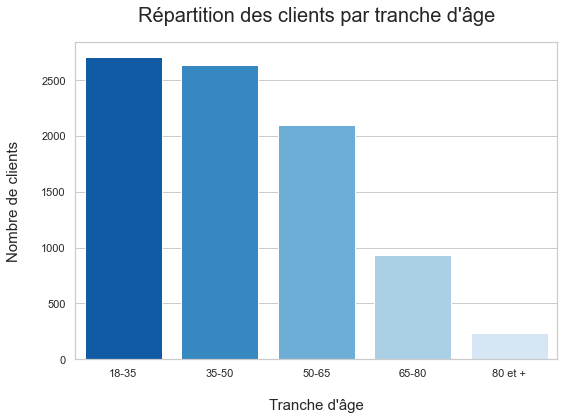

In [73]:
# Prepare graphic
plt.figure(figsize=(8,6))

sns.barplot(x="age_range" , y="occurence",data=client_by_age_range, palette = "Blues_r", saturation=1)

plt.xlabel("Tranche d'âge", fontsize = 15, labelpad=20)
plt.ylabel("Nombre de clients", fontsize = 15,labelpad=20)
plt.title("Répartition des clients par tranche d'âge", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

# Save graphic 
plt.savefig("img/clientsDistribByAge.png",  dpi=200, bbox_inches="tight")  

# Plot graphic
plt.show()

In [74]:
turnover_by_age=main_df.groupby('age_range').agg(turnover=('price','sum'),volume=('price','count')).reset_index()
turnover_by_age

,age_range,turnover,volume
0,18-35,3973866.14,130926
1,35-50,4424940.71,335364
2,50-65,2404381.49,150161
3,65-80,839482.24,50108
4,80 et +,214914.55,12773


#### Répartition du volume d'achat par tranche d'âge

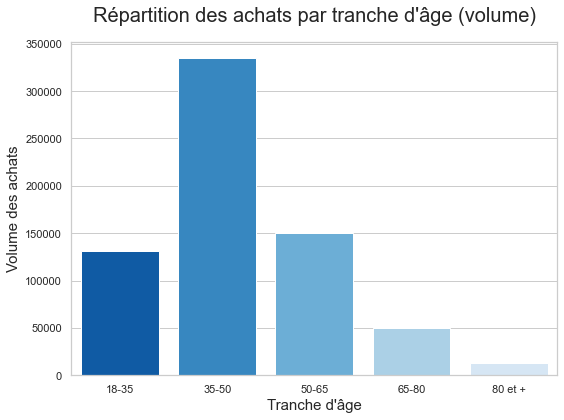

In [75]:
# Prepare graphic
plt.figure(figsize=(8,6))

sns.barplot(x="age_range" , y="volume",data=turnover_by_age, palette = "Blues_r", saturation=1)

plt.xlabel("Tranche d'âge", fontsize = 15)
plt.ylabel("Volume des achats", fontsize = 15)
plt.title("Répartition des achats par tranche d'âge (volume)", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

# Save graphic 
plt.savefig("img/volumeDistribByAge.png",  dpi=200, bbox_inches="tight") 

# Plot graphic
plt.show()

#### Répartition CA par tranche d'âge

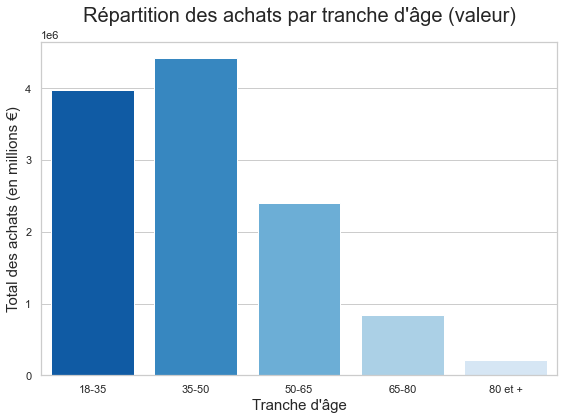

In [76]:
# Prepare graphic
plt.figure(figsize=(8,6))

sns.barplot(x="age_range" , y="turnover",data=turnover_by_age, palette = "Blues_r", saturation=1)

plt.xlabel("Tranche d'âge", fontsize = 15)
plt.ylabel("Total des achats (en millions €)", fontsize = 15)
plt.title("Répartition des achats par tranche d'âge (valeur)", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

# Save graphic 
plt.savefig("img/turnoverDistribByAge.png",  dpi=200, bbox_inches="tight") 

# Plot graphic
plt.show()

**<u>Observation<u>**<br>
La tranche d'âge 35-50 n'est pas la plus nombreuse mais achètent le plus.<br>
Les 18-35 ans achètent peu mais représente la seconde plus grosse part du CA.<br>
La majorité des clients a moins de 50 ans.

### Genre


In [77]:
distribution_by_gender=clients_df.groupby("sex").agg(number_of_clients=("sex","count")).reset_index()

number_of_w=distribution_by_gender["number_of_clients"][distribution_by_gender["sex"]=="f"].values[0]
number_of_m=distribution_by_gender[distribution_by_gender["sex"]=="m"]["number_of_clients"].values[0]

print(f"""A ce jour, la base de données est composée de {len(clients_df)} clients uniques dont {number_of_w} femmes et {number_of_m} hommes.
""")

A ce jour, la base de données est composée de 8600 clients uniques dont 4479 femmes et 4121 hommes.



In [78]:
distribution_by_gender

,sex,number_of_clients
0,f,4479
1,m,4121


#### Répartition Homme/Femme

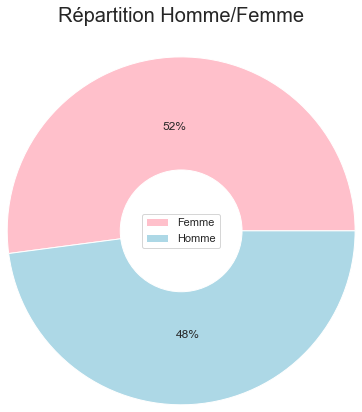

In [79]:
#Retrieving data
#Sex = distribution_by_gender["sex"] #not needed, used for labels but I hard coded the labels
distribution = distribution_by_gender["number_of_clients"]

# Create a white circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

colors = ['pink',"lightblue"]
labels=["Femme","Homme"]

#preparing the graph
plt.pie(distribution,colors=colors, labeldistance=0.5,autopct="%.0f%%", radius=2,pctdistance=0.6)

# from piechart to donut
p = plt.gcf()
p.gca().add_artist(my_circle)

#Legends and title
plt.title("Répartition Homme/Femme", pad=100, loc='center', fontsize=20)
plt.legend(labels, loc="center")

# Saving graphic
plt.savefig(fname='img/clientDistributionbyGender.png', dpi=200,bbox_inches ="tight") 

plt.show()

#### Répartition CA Homme/Femme

In [80]:
turnover_by_gender=main_df.groupby("sex").agg(total=("price","sum"),volume=('price','count')).reset_index()

In [81]:
turnover_by_gender

,sex,total,volume
0,f,5861724.78,338402
1,m,5995860.35,340930


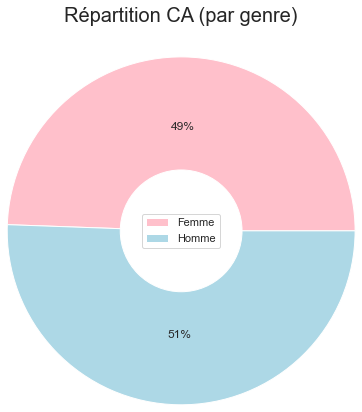

In [82]:
#Retrieving data
distribution = turnover_by_gender["total"]

# Create a white circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

colors = ['pink',"lightblue"]
labels=["Femme","Homme"]

#preparing the graph
plt.pie(distribution,colors=colors, labeldistance=0.5,autopct="%.0f%%", radius=2,pctdistance=0.6)

# from piechart to donut
p = plt.gcf()
p.gca().add_artist(my_circle)

#Legends and title
plt.title("Répartition CA (par genre)", pad=100, loc='center', fontsize=20)
plt.legend(labels, loc="center")

# Saving graphic
plt.savefig(fname='img/turnoverDistribByGender.png', dpi=200, bbox_inches ="tight")  

plt.show()

#### Répartition du volume d'achat Homme/Femme

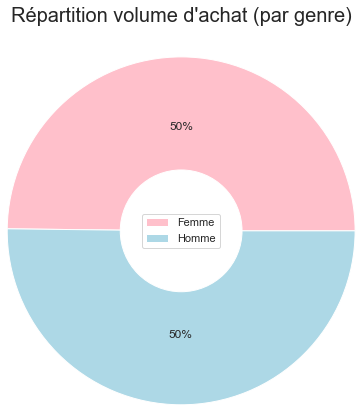

In [83]:
# Create a white circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

colors = ['pink',"lightblue"]
labels=["Femme","Homme"]

#preparing the graph
plt.pie(turnover_by_gender["volume"],colors=colors, labeldistance=0.5,autopct="%.0f%%", radius=2,pctdistance=0.6)

# from piechart to donut
p = plt.gcf()
p.gca().add_artist(my_circle)

#Legends and title
plt.title("Répartition volume d'achat (par genre)", pad=100, loc='center', fontsize=20)
plt.legend(labels, loc="center")

# Saving graphic
plt.savefig(fname='img/volumeDistribByGender.png', dpi=200, bbox_inches ="tight") 

plt.show()

**<u>Observations</u>**<br>
La répartition Homme/Femme est égalitaire

### Age et sexe

**Répartition par tranche d'âge et sexe**

In [84]:
turnover_by_age_range_and_sex=main_df.groupby(['age_range','sex']).agg(turnover=('price','sum')).reset_index()
turnover_by_age_range_and_sex

,age_range,sex,turnover
0,18-35,f,1882958.73
1,18-35,m,2090907.41
2,35-50,f,2134275.83
3,35-50,m,2290664.88
4,50-65,f,1261238.70
5,50-65,m,1143142.79
6,65-80,f,462426.43
7,65-80,m,377055.81
8,80 et +,f,120825.09
9,80 et +,m,94089.46


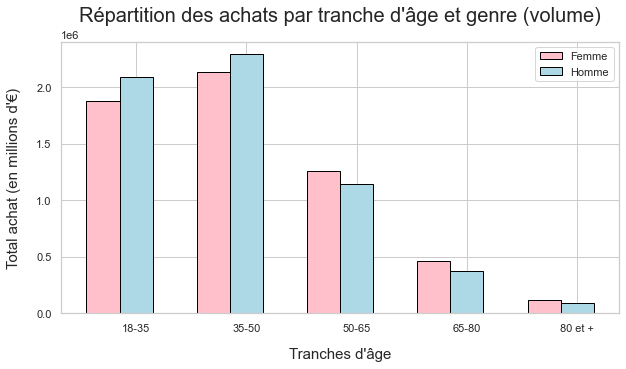

In [85]:
fig = plt.subplots(figsize=(10, 5))

# width of the bars
barWidth = 0.3
 
# Determine the height of the women bars
w_bars = turnover_by_age_range_and_sex["turnover"][turnover_by_age_range_and_sex["sex"]=="f"]
 
# Determine the height of the men bars
m_bars = turnover_by_age_range_and_sex["turnover"][turnover_by_age_range_and_sex["sex"]=="m"]

# The x position of bars
r1 = np.arange(len(w_bars))
r2 = [x + barWidth for x in r1]
 
# Create women bars
plt.bar(x=r1, height=w_bars, width =barWidth, color = 'pink', edgecolor = 'black', label='Femme')
 
# Create men bars
plt.bar(x=r2, height=m_bars, width = barWidth,  color = 'lightblue', edgecolor = 'black',   label='Homme')
 
# General layout
plt.xticks(ticks=[r + barWidth for r in range(len(m_bars))], labels=[turnover_by_age_range_and_sex["age_range"][turnover_by_age_range_and_sex["sex"]=="m"]][0])
plt.ylabel("Total achat (en millions d'€)", fontsize = 15,labelpad=15)
plt.xlabel("Tranches d'âge", fontsize = 15,labelpad=15)
plt.title("Répartition des achats par tranche d'âge et genre (volume)", fontsize = 20,loc='center', pad=20)
plt.legend()

# Save graphic 
plt.savefig("img/turnoverByAgeRange&Gender.png",  dpi=200, bbox_inches ="tight") 

# Show graphic
plt.show()

**Répartition par âge et sexe**

In [86]:
turnover_by_age_and_sex=main_df.groupby(['age','sex']).agg(turnover=('price','sum')).reset_index()

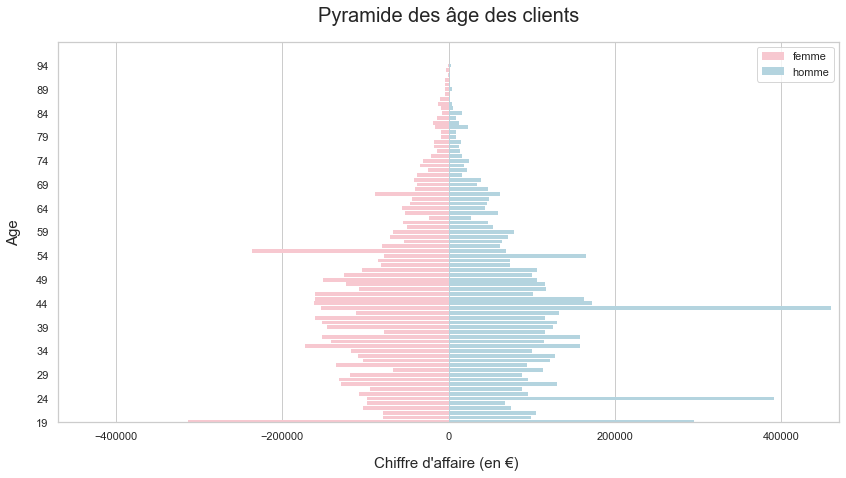

In [87]:
plt.figure(figsize=(14,7))
#sns.barplot(data=turnover_by_age_and_sex, x='turnover',y='age', hue='sex',orient='horizontal', dodge=False)

sns.barplot(x=-turnover_by_age_and_sex.turnover[turnover_by_age_and_sex["sex"]=="f"],y='age', data=turnover_by_age_and_sex, label="femme", color="pink", errwidth=0, orient='horizontal',lw=0) 
sns.barplot(x=turnover_by_age_and_sex.turnover[turnover_by_age_and_sex["sex"]=="m"], y='age', data=turnover_by_age_and_sex, label="homme", color="lightblue", errwidth=0,orient='horizontal',linewidth=0) 

plt.xlabel("Chiffre d'affaire (en €) ",fontsize = 15,labelpad=15)
plt.xlim(-470000,470000)

plt.ylabel("Age", fontsize = 15,labelpad=15)
plt.ylim(0, 1) # graph will be from min to max
plt.yticks(ticks=(np.arange(0,81, step=5)))

plt.title('Pyramide des âge des clients',fontsize=20, pad=20)

plt.legend(ncol=1, loc="upper right")

plt.savefig("img/turnoverByAge&Gender.png", dpi=200, bbox_inches="tight") 
plt.show()

### Habitudes d'achat


#### Panier moyen et nombre de produits achetés par session

In [88]:
shopping_habits_df=main_df.copy()
shopping_habits_df=shopping_habits_df.groupby(["session_id"]).agg(number_of_products=('id_prod','count'),total_basket=('price','sum')).reset_index()

In [89]:
shopping_habits_df

,session_id,number_of_products,total_basket
0,s_1,1,11.99
1,s_10,1,26.99
2,s_100,2,33.72
3,s_1000,4,39.22
4,s_10000,3,41.49
...,...,...,...
342310,s_99994,3,28.92
342311,s_99995,1,19.84
342312,s_99996,4,56.27
342313,s_99997,1,6.99


In [90]:
nop_mean=np.mean(shopping_habits_df.number_of_products)
tp_mean=np.mean(shopping_habits_df.total_basket)
print(f"Les clients achètent en moyenne {nop_mean:.0f} produits pour un montant moyen de {tp_mean:.2f} €")

Les clients achètent en moyenne 2 produits pour un montant moyen de 34.64 €


#### Analyse de la concentration des dépenses

Permet de regarder si l'argent dépensé sur le site est réparti de manière égalitaire ou pas par les clients.

Méthode : 
- Courbe de Lorenz
- Calcul de l'indice de Geni (surface entre 1ère bissectrice et la courbe de Lorenz)

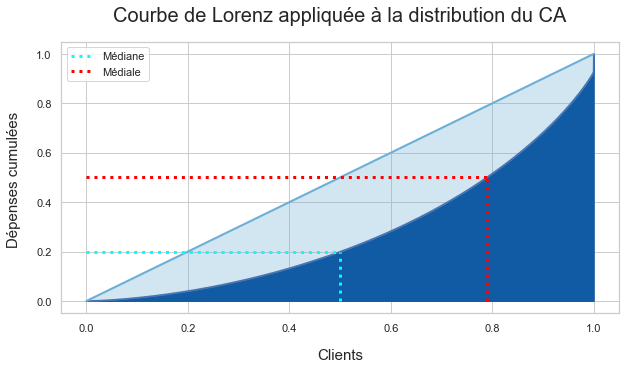

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))

# Lorenz curve
expenses=main_df.groupby("client_id")["price"].sum()
n = len(expenses) #number of unique clients

lorenz = (np.cumsum(np.sort(expenses)) / expenses.sum())  # cumulative sum on the sorted dataset
lorenz = np.append([0],lorenz) # Lorenz curve starts at 0, I add 0 on dataset

xaxis = np.linspace(0,1,n+1) # axis goes from 0 to 1. Formula to get evenly spaced number linspace (start=x1, stop=x2, numberOfDots=n) -> space between each dot is (x2-x1) / (n-1)

plt.plot(xaxis,lorenz)

#Drawing the bisector
plt.plot([0, 1], [0, 1], color='#6caed6', linestyle='-', linewidth=2) 

#Labels
plt.ylabel('Dépenses cumulées ', fontsize = 15,labelpad=15)
plt.xlabel("Clients", fontsize = 15,labelpad=15)
plt.title("Courbe de Lorenz appliquée à la distribution du CA", fontsize = 20,loc='center', pad=20)

ax.fill_between(xaxis, lorenz, color="#105ba4")
ax.fill_between(xaxis, xaxis, lorenz, color='#6caed6', alpha=0.3)

# Calculation and positionning of the median and medial
median = lorenz[int(round(len(lorenz)) / 2)] # retrievieng the value at half of the dataset
plt.plot([0.5, 0.5], [0, median], color='cyan', linestyle=':', linewidth=3, label="Médiane")
plt.plot([0, 0.5], [median, median], color='cyan', linestyle=':', linewidth=3)

medial = len(lorenz[lorenz <= 0.5]) / len(lorenz) # medial is found at half of the height
plt.plot([0, medial], [0.5, 0.5], color='red', linestyle=':', linewidth=3, label="Médiale")
plt.plot([medial, medial], [0, 0.5], color='red', linestyle=':', linewidth=3)

plt.legend(loc="best")

#Saving graph
plt.savefig("img/LorenzCurve.png",  dpi=200, bbox_inches="tight") 


plt.show()

Calcul de l'indice de Gini

In [92]:
lorenz=lorenz #gini is expressed by a number varying between 0 and 1.
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n #Area unbder Lorenz curve. The 1st segment (lorenz[0]) is half below 0, we cut it in half, and we do the same with the last segment lorenz[-1] which is half above 1.
S = 0.5 - AUC # Area between 1st bisector and Lorenz curve
gini = 2*S

print (f"""L'indice de gini vaut {gini:.2f}.
La dépense médiale se situe à {medial:.2%}
""")

L'indice de gini vaut 0.45.
La dépense médiale se situe à 78.91%



**<u>Observation</u><br>**
80% des clients représentent 50% du CA, donc 20% des clients concentrent 50% du CA.<br>
L'indice de gini confirme la répartition non égalitaire.


# Recherche de corrélation entre les variables

- Lien entre le genre d’un client et les catégories des livres achetés
- Lien entre l’âge des clients  et 
    - le montant total des achats, 
    - la fréquence d’achat, 
    - la taille du panier moyen 
    - les catégories des livres achetés. 

**Méthode**<br>
- Je passse la colonne session_id au format date.<br>
- Je transforme le type de la catégorie *(1)* de int à string (même si catégorie est un entier compris entre 0 et 2, ça ne représente rien, c'est un ID lié à un libellé existant dans une autre table).

*(1) Je vais avoir besoin que cette variable soit qualitative pour couvrir le spectre des différents tests validant les hypothèses d'indépendance:*
   - Comparer 2 variables quantitatives
   - Comparer 2 variables qualitatives
   - Comparer 1 variable quantitative et 1 variable qualitative

Création du dataframe

In [93]:
bivariate_df=main_df.copy()
bivariate_df.drop(columns=["birth","purchase_year", "purchase_year_month", "age_range"], inplace=True) , #"age_range""purchase_month",
bivariate_df["date"]=pd.to_datetime(bivariate_df["date"]).dt.date  
bivariate_df

,id_prod,date,session_id,client_id,sex,price,categ,age
0,0_1518,2022-05-20,s_211425,c_103,f,4.18,0,37
1,1_251,2022-02-02,s_158752,c_8534,m,15.99,1,35
2,0_1277,2022-06-18,s_225667,c_6714,f,7.99,0,55
3,2_209,2021-06-24,s_52962,c_6941,m,69.99,2,23
4,0_1509,2023-01-11,s_325227,c_4232,m,4.99,0,43
...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15,s_150195,c_8489,f,12.99,0,72
679328,1_639,2022-03-19,s_181434,c_4370,f,10.99,1,46
679329,0_1425,2022-12-20,s_314704,c_304,f,12.99,0,35
679330,0_1994,2021-07-16,s_63204,c_2227,m,4.98,0,37


Conversion de *categ* en int

In [94]:
print(bivariate_df.categ.dtypes)

int64


In [95]:
bivariate_df["categ"]=bivariate_df.categ.astype('str')

In [96]:
print(bivariate_df.categ.dtypes)

object


## Lien entre l'âge des clients et les catégories des livres achetés 

Il s'agit ici d'analyser une variable quantitative discrète (âge) et une variable qualitative nominale (catégorie).

### Test paramétrique ANOVA

**Méthode**<br>

Dans une ANOVA, on cherche à déterminer si les moyennes des groupes sont significativement différentes.<br>

**Hypothèses**
* Hypothèse 0 (H0) = Hypothèse nulle, les moyennes de chaque groupe sont égales et il n'y pas de relation ou de différence si alpha > 0.05 <br>
* Hypothèse Alternative (H1) = Les moyennes de chaque groupe ne sont pas toutes égales, il existe une relation entre les variables si alpha < 0.05 <br>
* Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.

<u>Note</u><br>
Quand on dispose d’un petit échantillon, la pertinence de ce test repose sur la validation de plusieurs hypothèses (qui valide que les variables suivent une loi normale):

* l’indépendance entre les échantillons de chaque groupe : c'est vérifié par le contexte, il n'y a pas de test à réaliser. **On considère ici que les échantillons sont bien indépendants.**
* l’égalité des variances que l’on peut vérifier avec un test de **Bartlett**.
* la normalité des résidus avec un test de **Shapiro**.

**Nous allons le faire ici, même si la taille de notre échantillon ne le requiert pas.**


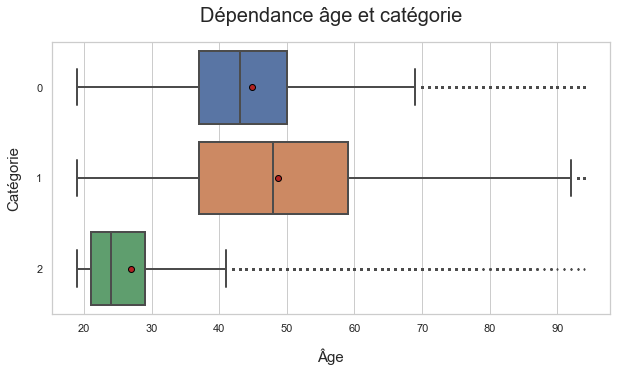

In [97]:
plt.subplots(figsize=(10,5))

meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

ax = sns.boxplot(x="age", y="categ", data=bivariate_df, linewidth=2,fliersize=1.5,orient="h",meanprops=meanprops,showmeans=True)

plt.xlabel("Âge", fontsize = 15, labelpad=15)
plt.ylabel("Catégorie", fontsize = 15, labelpad=15)
plt.title("Dépendance âge et catégorie", fontsize = 20,loc='center', pad=20)

plt.savefig("img/relationAgeCategory.png", dpi=200, bbox_inches='tight')
plt.show()

**<u>Observation</u><br>**
Au 1er regard, il semble y avoir une dépendance entre la catégorie 2 et les personnes jeunes (21 et 28 ans).<br>
Essayons de confirmer cela par le test ANOVA de comparaison de moyennes.

In [98]:
model = ols('age ~ categ', data=bivariate_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
categ,1.489749e+07,2.0,45883.780589,0.0
Residual,1.102818e+08,679329.0,NaN,NaN


**<u>Observation</u><br>**
Les moyennes sont significativement différentes avec un p-value valant 0. Il n'y a pas de risque de se tromper. <br> 
Je vérifie tout de même la validité du test ANOVA en contrôlant les conditions (test de normalité).

**Egalité des variances**

Le test de bartlett permet de tester si les variances sont significativement différentes ou non.

H0 : Les variances de chaque groupe sont égales si p-value > 0.05<br>
Ha : Les variances de chaque groupe ne sont pas toutes égales si p-value < 0.05

In [99]:
bivariate_df.groupby("categ")['age'].agg('var')

categ
0    125.652495
1    240.123223
2     96.003604
Name: age, dtype: float64

In [100]:
bartlett(bivariate_df.age[bivariate_df.categ == "0"],
        bivariate_df.age[bivariate_df.categ == "1"],
        bivariate_df.age[bivariate_df.categ == "2"])

BartlettResult(statistic=36719.89444607752, pvalue=0.0)

**<u>Observation</u><br>**
P-value vaut 0, les variances ne sont pas du tout égales.<br>
On regarde quand même l'égalité des résidus, mais le test Anova ne peut pas être utilisé puisque la condition n'est pas remplie.

**Normalité des résidus**

L’objectif est de s’assurer que les résidus suivent une loi normale afin de ne pas affirmer qu’il existe une différence de moyenne entre les groupes qui serait causée par le hasard.

On utilise le test de Shapiro-Wilk pour tester la normalité des résidus où :

H0 : Les résidus suivent une loi normale si p-value > 0.05<br>
Ha : Les résidus ne suivent pas une loi normale si p-value < 0.05


In [101]:
model = ols('age ~ categ', data=bivariate_df).fit()
shapiro(model.resid)

/Users/laetitia/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9703239798545837, pvalue=0.0)

**<u>Observation</u><br>**
P-value valant 0, les résidus ne suivent pas de loi normale.

**<u>Conclusion</u><br>**
**Il n'est donc pas conseillé de réaliser une ANOVA car les résultats ne seraient pas fiables (si on disposait d'un petit échantillon).<br>
Il faut passer à un test non paramétrique.**

### Test non paramétrique Kruskal-Wallis

**Méthode**

Le test de Kruskal-Wallis est un test robuste non paramétrique. Il n'y a pas besoin de conditions préalables pour l'appliquer.<br>
Il permet de savoir, pour une variable pour laquelle on dispose de plusieurs catégories, si au moins une catégorie diffère.<br>
Comme il s'applique à la médiane, il peut passer en force même si les valeurs ne se répartissent pas selon la loi normale : il remplace ANOVA lorsque l'une des conditions préalables n'a pas été remplie.

**Hypothèses**

Elles restent identiques à celle de l'ANOVA

In [102]:
stats.kruskal(bivariate_df.age[bivariate_df.categ=="0"],bivariate_df.age[bivariate_df.categ=="1"],bivariate_df.age[bivariate_df.categ=="2"])

KruskalResult(statistic=79350.86927924873, pvalue=0.0)

**<u>Conclusion</u><br>**
**On rejette l'hypothèse nulle sans risque d'erreur et on acte qu'il existe un lien entre l'âge et la catégorie.<br>
Au moins une catégorie diffère des autres : on le voit bien sur le graphique, la catégorie des plus jeunes, jusqu'à 29 ans, achètent principalement des livres de la catégorie 2.**

## Lien entre : âge et achats (montant total des achats et panier moyen)
Analyse portant sur des variables de types quantitatives (âge, panier moyen et total des achats).

### Test de corrélation Spearman

Je vais avoir besoin de calculer le panier moyen et le montant total des achats.<br>

**Méthode**<br>
Ajout de 2 colonnes à mon dataframe:
- Calcul du panier moyen (par client) : CA / Nombre de commandes => Utilisation de la fonction mean
- Montant total des achats (par client) : Somme des achats


**Hypothèses**<br>
- H0 : Variables indépendantes si p-value > alpha,<br>
- H1 : Variables dépendantes si p-value < alpha,<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.


In [103]:
age_basket_df=main_df.copy()

In [104]:
age_basket_df.head(1)

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_year_month,age,age_range
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,2022-05,37,35-50


In [105]:
age_basket_df=age_basket_df.groupby(['client_id', 'age']).agg(avg_basket_size=('price','mean'),total_purchase=('price','sum')).reset_index()

In [106]:
age_basket_df

,client_id,age,avg_basket_size,total_purchase
0,c_1,68,14.312308,558.18
1,c_10,67,23.337931,1353.60
2,c_100,31,31.856250,254.85
3,c_1000,57,18.095120,2261.89
4,c_1001,41,17.773137,1812.86
...,...,...,...,...
8595,c_995,68,13.529286,189.41
8596,c_996,53,17.111368,1625.58
8597,c_997,29,25.254407,1490.01
8598,c_998,22,52.450566,2779.88


Avant de réaliser des tests d'indépendance, on projette graphiquement les données 2 à 2

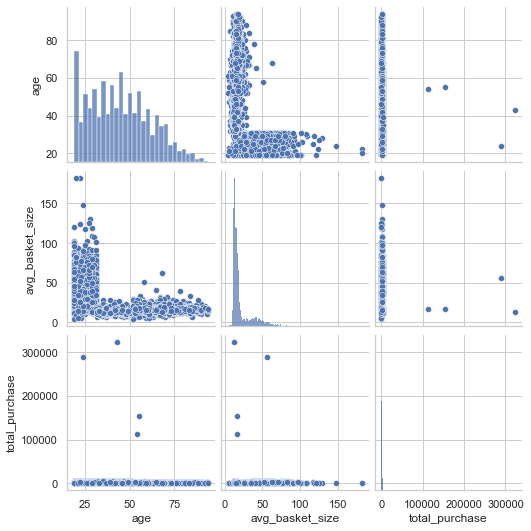

In [107]:
ax=sns.pairplot(age_basket_df.iloc[:,:])
ax.savefig("img/pairplotOutliers.png",dpi=200, bbox_inches="tight")

**<u>Observation<u><br>**
On voit clairement 4 outliers qui ont un énorme total d'achat par rapport aux autres clients.<br>
Il s'agit certainement d'entreprises, d'établissement d'enseignement, ou autre, qui n'ont pas les mêmes besoins que les particuliers : nous n'avons pas d'autres informations à ce sujet.<br>
Il faut les identifier et les supprimer pour cette partie du test, mais je les laisse dans le reste des analyses, notament univariées, car il n'y a que 4 clients identifiés :<br>
le volume ne fausse pas vraiment les informations de répartition de sexe, de genre, d'âge,...et il est important de les conserver pour l'impact sur le CA.<br>

J'identifie les clients outliers pour ensuite les supprimer.

In [108]:
outliers_client_df=main_df.groupby('client_id', as_index=False).agg(total_achat=('price','sum')).sort_values("total_achat").tail(4)
outliers_client=outliers_client_df.iloc[:,0]
outliers_client

2724    c_3454
6337    c_6714
4388    c_4958
677     c_1609
Name: client_id, dtype: object

Analyse sur le poids que représente ces clients sur le CA

In [109]:
outliers_clients_sum=outliers_client_df.total_achat.sum()
outliers_clients_sum

prop_big_clients=outliers_clients_sum/total_turnover

print (f"Les {len(outliers_client_df)} clients identifiés comme non particuliers représentent {prop_big_clients:.2%} des ventes.")

Les 4 clients identifiés comme non particuliers représentent 7.43% des ventes.


In [110]:
age_basket_df.drop(outliers_client.index, inplace=True)

Vérification de la bonne prise en compte de la suppression

In [111]:
age_basket_df.shape

(8596, 4)

In [112]:
age_basket_df[age_basket_df.client_id=='c_3454']

,client_id,age,avg_basket_size,total_purchase


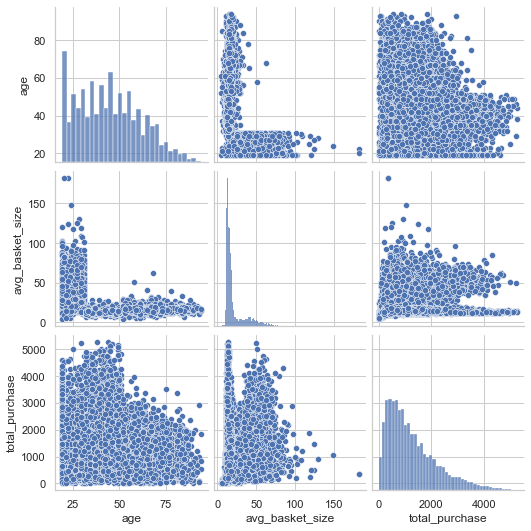

In [113]:
ax=sns.pairplot(age_basket_df.iloc[:,:])

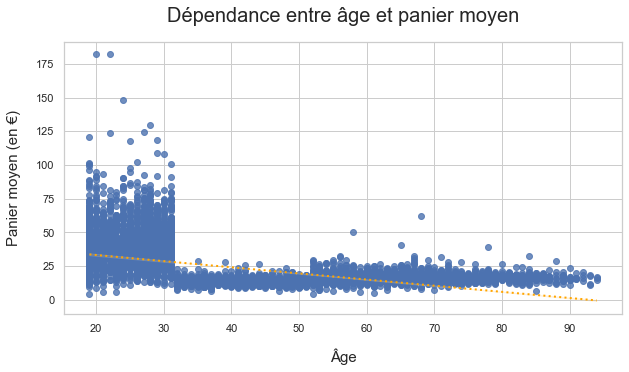

In [114]:
plt.subplots(figsize=(10,5))
sns.regplot(x=age_basket_df["age"], y=age_basket_df["avg_basket_size"],line_kws={'lw': 2, 'color': 'orange','linestyle':':'})

plt.xlabel("Âge", fontsize = 15, labelpad=15)
plt.ylabel("Panier moyen (en €)", fontsize = 15, labelpad=15)
plt.title("Dépendance entre âge et panier moyen", fontsize = 20,loc='center', pad=20)

plt.savefig("img/relationAgeAverageBasket.png", dpi=200, bbox_inches="tight")

plt.show()

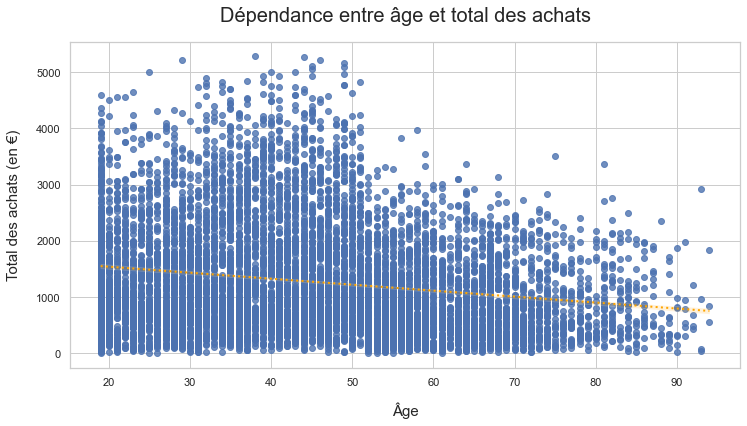

In [115]:
plt.subplots(figsize=(12,6))
sns.regplot(data=age_basket_df, x="age", y="total_purchase",line_kws={'lw': 2, 'color': 'orange','linestyle':':'})

plt.xlabel("Âge", fontsize = 15, labelpad=15)
plt.ylabel("Total des achats (en €)", fontsize = 15, labelpad=15)
plt.title("Dépendance entre âge et total des achats", fontsize = 20,loc='center', pad=20)

plt.savefig("img/relationAgeTotalProcurement.png", dpi=200)

plt.show()

Mise en place de la matrice de corrélation avec la méthode Spearman (car nos données ne sont pas normalisées).

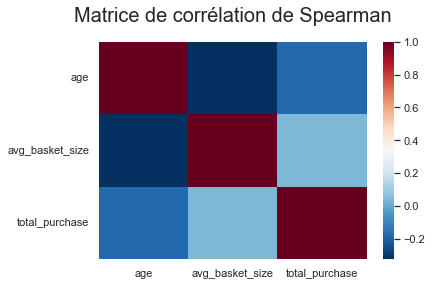

In [116]:
df_corr = age_basket_df.corr(method="spearman")

ax = sns.heatmap(df_corr, cmap = 'RdBu_r').set_title("Matrice de corrélation de Spearman", fontsize=20, pad=20)

Amélioration de la matrice de corrélation en supprimant la partie haute du triangle qui est redondante, et en ajoutant des paramètres d'affichage (couleur, échelle, résultat corrélation).

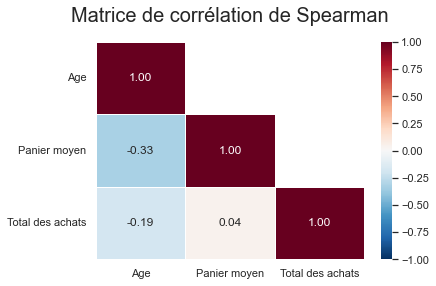

In [117]:
mask = np.triu(np.ones_like(df_corr,dtype=bool),k=1)

sns.heatmap(df_corr, cmap = 'RdBu_r', mask=mask, annot=True, center=0, vmin=-1,vmax=1, fmt=".2f", linewidths=1,xticklabels =["Age", "Panier moyen", "Total des achats"],yticklabels =["Age", "Panier moyen", "Total des achats"])

plt.title("Matrice de corrélation de Spearman", fontsize=20, loc='center', pad=20)

plt.savefig("img/relationAgeProcurementSpearman.png", dpi=200, bbox_inches="tight")

plt.show()

In [118]:
print(f"""Age vs Panier moyen : {spearmanr(age_basket_df.age,age_basket_df.avg_basket_size)}
Age vs Total achat : {spearmanr(age_basket_df.age,age_basket_df.total_purchase)}""")

Age vs Panier moyen : SpearmanrResult(correlation=-0.3261618355177031, pvalue=3.3241215627402095e-212)
Age vs Total achat : SpearmanrResult(correlation=-0.1850724830169425, pvalue=4.229007870955309e-67)


**<u>Conclusion</u><br>**
**La matrice de corrélation négative nous montre qu'il y a un lien entre l'âge et le panier moyen, et l'âge et le total des achats : plus le client est âgé, moins il achète.<br>
Les 19-31 ans ont le plus gros panier moyen.<br>
Les 19-50 ans achètent ont dépensé le plus depuis 2 ans.
La p-value valide les hypothèses de dépendances des variables.**

## Lien entre le genre des clients et les catégories des livres achetés 

Il s'agit ici d'analyser 2 variables qualitatives.


### Test de Khi²

L'intérêt du test du **Khi²** est de mesurer l'indépendance entre deux variables qualitatives à partir du tableau de contigence.

**Méthode :**

Je créé un tableau de contingence qui va me permettre de générer une heat map et de valier l'observation par le test.<br>

**Hypothèses :**

On pose les hypothèses de départ :

- H0 : Variables indépendantes si p-value > alpha,<br>
- H1 : Variables dépendantes si p-value < alpha,<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.

Chaque case du tableau de contingence compte un nombre d'individus. Ce comptage se fait grâce à la fonction  len.<br>
margins permet d'obtenir le total de chaque ligne et colonne. On pourrait ne pas l'afficher, il ne nous sert pas dans la suite.

In [119]:
sex_categ_contingency=bivariate_df[["sex","categ"]].pivot_table(index="categ",columns="sex", aggfunc=len, margins_name="Total", margins=True)
sex_categ_contingency

sex,f,m,Total
categ,,,
0,206220,209460,415680
1,114899,112270,227169
2,17283,19200,36483
Total,338402,340930,679332


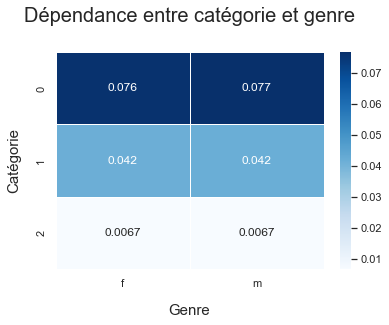

In [120]:
tx = sex_categ_contingency.loc[:,["Total"]]
ty = sex_categ_contingency.loc[["Total"],:]
n = len(sex_categ_contingency)
indep = tx.dot(ty) / n

c = sex_categ_contingency.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

sns.heatmap(table.iloc[:-1,:-1],annot=True, linewidths=1, cmap="Blues") # Exclusion of the "Total" data

# General layout
plt.ylabel("Catégorie", fontsize = 15,labelpad=15)
plt.xlabel("Genre", fontsize = 15,labelpad=15)
plt.title("Dépendance entre catégorie et genre", fontsize = 20,loc='center', pad=30)

# Save graphic
plt.savefig("img/relationProcurementByCateg&Gender.png", dpi=200, bbox_inches="tight")
plt.show()

In [121]:
sex_categ_contingency.iloc[:-1,:-1]

sex,f,m
categ,,
0,206220,209460
1,114899,112270
2,17283,19200


Test du Khi2 d'indépendance

In [122]:
Khi2_obs, p, dof, expected = chi2_contingency(sex_categ_contingency.iloc[:-1,:-1]) # I exclude the "Total" data of the contingency dataframe to execute my test

print(f"""chi² : {Khi2_obs}
p-value : {p}
Degré de liberté : {dof}
""")

chi² : 147.00253568681114
p-value : 1.1989607410166063e-32
Degré de liberté : 2



### Test de Cramer
Malgré le résultat de lap-value qui valide une dépendance, la corrélation semble assez faible et peu marquée sur la heatmap (voir coefficient de corrélation), chaque genre achètant dans les mêmes proportions la même catégorie de livres.<br>
Je mesure la force de l'association V-Cramer pour établir l'intensité de la relation genre / catégorie.

In [123]:
#Chi-squared test statistic, sample size, and minimum of rows and columns
n = np.sum(sex_categ_contingency)
minDim = min(sex_categ_contingency.shape)-1

#calculate Cramer's V 
V = np.sqrt((Khi2_obs/n) / minDim)

#display Cramer's V
print(f"Le coefficident de Cramer vaut {V[2]}")
if V[2] < 0.1 :
    print("La relation est nulle ou très faible.")
if 0.1<= V[2] < 0.2 :
    print("La relation est faible.")
if 0.2<= V[2] < 0.3 :
    print("La relation est moyenne.")
if  V[2] >= 0.3 :
    print("La relation est forte.")


Le coefficident de Cramer vaut 0.007355147408737641
La relation est nulle ou très faible.


**<u>Conclusion</u><br>**
**La p-value étant largement inférieure à notre seuil alpha, on accepte sans risque l'hypothèse que la catégorie et le genre de clients sont  liés. On voit que la catégorie 0 est la plus achetée.<br>
Toutefois, la relation est très faible d'après le résultat du v-cramer, et la corrélation est donc peu significative. <br>
Les clients masculin comme féminin achètent les mêmes catégories de livres.**

## Lien entre l'âge et la fréquence d'achat
L'analyse porte sur 2 variables quantitatives.

### Test de corrélation de Spearman

**Méthode :**<br>
Je calcule la fréquence d'achat en comptabilisant le nombre de session par client que je divise par le nombre de mois.

**Hypothèses :<br>**
- H0 : Variables indépendantes si p-value > alpha<br>
- H1 : Variables dépendantes si p-value < alpha<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.



In [124]:
nb_months=len(main_df.purchase_year_month.unique())
nb_months

24

Je fais d'abord un groupby sur le client et la session pour ne garder que les achats d'une même commande.<br>
Je divise ce chiffre par mon unité de temps pour avoir la fréquence d'achat.

In [125]:
age_purchase_freq=main_df.copy().groupby(['client_id','age'], as_index=False).agg(nb_session=('session_id','count')).sort_values("nb_session")
age_purchase_freq["purchase_freq"]=age_purchase_freq.nb_session/nb_months

Je supprime les clients outliers identifiés plus haut.

In [126]:
age_purchase_freq.drop(outliers_client.index, inplace=True)

In [127]:
age_purchase_freq

,client_id,age,nb_session,purchase_freq
3576,c_4223,72,1,0.041667
694,c_1624,31,1,0.041667
1556,c_240,25,1,0.041667
4044,c_4648,19,1,0.041667
5868,c_6292,31,1,0.041667
...,...,...,...,...
708,c_1637,35,380,15.833333
1197,c_2077,39,384,16.000000
1772,c_2595,49,398,16.583333
1268,c_2140,46,402,16.750000


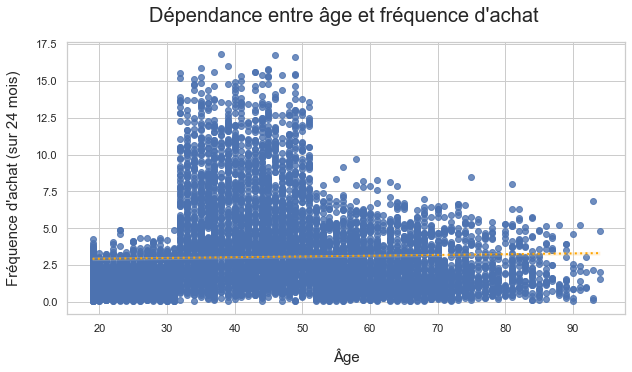

In [128]:
plt.subplots(figsize=(10,5))
sns.regplot(x=age_purchase_freq["age"], y=age_purchase_freq["purchase_freq"],line_kws={'lw': 2, 'color': 'orange','linestyle':':'})

plt.xlabel("Âge", fontsize = 15, labelpad=15)
plt.ylabel("Fréquence d'achat (sur 24 mois)", fontsize = 15, labelpad=15)
plt.title("Dépendance entre âge et fréquence d'achat ", fontsize = 20,loc='center', pad=20)

plt.savefig("img/relationAgePurchaseFreq.png", dpi=200,  bbox_inches="tight")

plt.show()

Mise en place de la matrice de corrélation avec la méthode Spearman (car nos données ne sont pas normalisées).

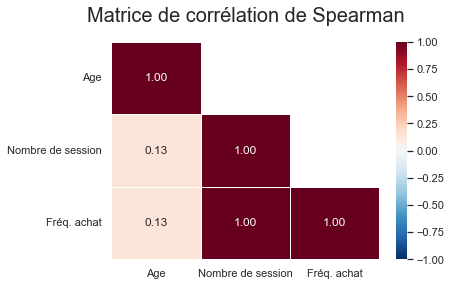

In [129]:
age_purchase_freq_corr = age_purchase_freq.corr(method="spearman")

mask = np.triu(np.ones_like(age_purchase_freq_corr,dtype=bool),k=1)

sns.heatmap(age_purchase_freq_corr, cmap = 'RdBu_r', mask=mask, annot=True, center=0, vmin=-1,vmax=1, fmt=".2f", linewidths=1,xticklabels = ["Age", "Nombre de session","Fréq. achat"] ,   yticklabels = ["Age", "Nombre de session","Fréq. achat"])

plt.title("Matrice de corrélation de Spearman", fontsize = 20,loc='center', pad=20)

plt.savefig("img/relationAgePurchaseFreqSpearman.png", dpi=200, bbox_inches="tight")
plt.show()

In [130]:
print(f"Age vs. Fréquence d'achat : {spearmanr(age_purchase_freq.age,age_purchase_freq.purchase_freq)}")

Age vs. Fréquence d'achat : SpearmanrResult(correlation=0.12829742372670497, pvalue=7.088426379034454e-33)


**<u>Conclusion</u><br>
Le graphique et le résultat du test confirment le lien de relation (faible) entre la fréquence d'achat et l'âge : ce sont les 32-51 ans qui achètent le plus souvent.**

## Probabilité 
Calcul de la probabilité qu'un client achète la ref B sachant qu'il a acheté la ref A

In [131]:
# Dataframe to have the number of purchases per customer for each product
proba_df=transactions_df.groupby(["client_id","id_prod"]).agg(nb_achat=("id_prod","count")).reset_index()

In [132]:
# Pivoting dataframe to have products in columns, and clients in rows.
proba_pivot_df=proba_df.pivot_table(index="client_id",columns ="id_prod", values="nb_achat",fill_value=0)#, aggfunc=len
proba_pivot_df

id_prod,0_0,0_1,0_10,0_100,0_1000,0_1001,0_1002,0_1003,0_1004,0_1005,...,2_90,2_91,2_92,2_93,2_94,2_95,2_96,2_97,2_98,2_99
client_id,,,,,,,,,,,,,,,,,,,,,
c_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c_100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c_1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c_1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c_996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c_997,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
def probability_of_B_knowing_A (df,producta, productb):

    """
    Function :
        Retrieve the probability of an event B knowing event A
    Formula : 
        Intersection : P(A∩B)=P(A)etP(B) 
        Probability of B knowing A : P(B∣A)= P(B∩A)/ P(A)
    Parameters :
        The pivoted dataframe
        Product A 
        Product B
    Calculations:
        We want to know how many customer bought a given book.
        For each client who bought a book A, we enter 1. Otherwise, 0.
        Same for book B.
        Intersection : a customer has bought both A and B. We add a column which is the sum of the 2 previous ones. And then we replace 2 by 1.
        Now we can have the percentage of probability A, probability B, and probability of the intersection 
    """
    df=df.loc[:,[producta,productb]]
    df[producta] = df[producta].apply(lambda x: 1 if x > 0 else 0)
    df[productb] = df[productb].apply(lambda x: 1 if x > 0 else 0)
    df["producta_and_b"] = df[producta]+df[productb]
    df["producta_and_b"] = df["producta_and_b"].apply(lambda x:1  if x == 2 else 0)
    
    proba_a=df[producta].sum()/df[producta].count()
    
    proba_b=np.mean(df[productb])
    
    prob_a_inter_b=np.mean(df["producta_and_b"])
    
    p_b_knowing_a=prob_a_inter_b/proba_a

    return print(f"""La probabilité qu'un client achète le livre {productb} sachant qu'il a acheté le livre {producta} est de {p_b_knowing_a:.2%} 
Probabilité d'achat du livre "A" référencé {producta} : {proba_a:.2%}
Probabilité d'achat du livre "B" référencé {productb} : {proba_b:.2%}
Probabilité d'acheter le livre "A et B"  : {prob_a_inter_b:.2%}.""")

In [134]:
probability_of_B_knowing_A (proba_pivot_df,'2_159','1_369')

La probabilité qu'un client achète le livre 1_369 sachant qu'il a acheté le livre 2_159 est de 16.23% 
Probabilité d'achat du livre "A" référencé 2_159 : 6.16%
Probabilité d'achat du livre "B" référencé 1_369 : 10.71%
Probabilité d'acheter le livre "A et B"  : 1.00%.


Vérification manuelle

In [135]:
proba_pivot_df["a"] = proba_pivot_df["2_159"].apply(lambda x: 1 if x > 0 else 0)
proba_pivot_df["b"] = proba_pivot_df["1_369"].apply(lambda x: 1 if x > 0 else 0)
proba_pivot_df["producta_and_b"] = proba_pivot_df.a+proba_pivot_df.b
proba_pivot_df["producta_and_b"]= proba_pivot_df["producta_and_b"].apply(lambda x: 1 if x == 2 else 0)
proba_pivot_df.loc[:,['2_159','1_369','a','b','producta_and_b']].to_csv('pouet.csv')